# **Heterogeneous GraphSAGE – LightGBM Ensemble on Edge Embeddings**

This notebook implements the ensemble model, where a LightGBM classifier is trained on **fixed edge embeddings** generated by the best-performing **EdgeAwareHeteroSAGE** model.

<br>

**Requirements**

To run this notebook, the following needs to be loaded:

* `graph_15features_scaled_balanced.pt`
* `best_search_model.pt`
* `search_summary.json`

<br>

**Prerequisites**

Before running this notebook:

* **Script 1** (`hetero_graphsage_build_graph.py`) must have produced:
  * **`graph_15features_scaled_balanced.pt`**
* **Script 2** (training, hyperparameter search, evaluation) must have produced:
  * **`best_search_model.pt`**
  * **`search_summary.json`**

# Importing library

In [1]:
# !pip install torch_geometric pyg_lib torch_scatter torch_sparse torch_cluster -f https://data.pyg.org/whl/torch-$(python -c 'import torch; print(torch.__version__)').html

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 161.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 133.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 127.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00


In [2]:
import os
import ast
import json
import time
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.transforms import ToUndirected

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay

from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.nn import HeteroConv, SAGEConv
import torch_geometric.transforms as T

import lightgbm as lgb

# comment out if not running on google colab
from google.colab import drive
drive.mount("/content/drive")

DATA_DIR = "/content/drive/MyDrive/" #edit accordingly

Mounted at /content/drive


# Set up

In [3]:
DATA_DIR = "/content/drive/MyDrive/"
GRAPH_PATH = os.path.join(DATA_DIR, "graph_15features_scaled_balanced.pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

print("Loading graph from:", GRAPH_PATH)
data = torch.load(GRAPH_PATH, map_location="cpu", weights_only=False)

data = ToUndirected()(data)
data_cpu = data.to("cpu")

METADATA  = data.metadata()
EDGE_TYPE = ('user', 'transaction', 'merchant')
EDGE_DATA = data[EDGE_TYPE]

EDGE_CH   = EDGE_DATA.edge_attr.shape[1]
IN_CH     = data['user'].x.shape[1]

print("IN_CH =", IN_CH, "| EDGE_CH =", EDGE_CH)

Using device: cuda
Loading graph from: /content/drive/MyDrive/graph_15features_scaled_balanced.pt
IN_CH = 128 | EDGE_CH = 15


In [6]:
class EdgeAwareHeteroSAGE(nn.Module):
    def __init__(self, metadata, in_channels, hidden_channels, out_channels, edge_feature_dim,
                 dropout_p=0.3, aggr_rel='mean', aggr_sage='mean'):
        super().__init__()
        self.dropout_p = dropout_p

        # Encoder
        # Hetero GraphSAGE layers
        self.conv1 = HeteroConv(
            {et: SAGEConv((-1, -1), hidden_channels, aggr=aggr_sage) for et in metadata[1]},
            aggr=aggr_rel
        )
        self.conv2 = HeteroConv(
            {et: SAGEConv((-1, -1), out_channels, aggr=aggr_sage) for et in metadata[1]},
            aggr=aggr_rel
        )

        # Edge-Aware Decoder
        # 1. MLP to project edge features to the same dimension as node embeddings
        hidden_mlp_width = max(32, edge_feature_dim)
        self.edge_proj = nn.Sequential(
            nn.Linear(edge_feature_dim, hidden_mlp_width),
            nn.ReLU(),
            nn.Linear(hidden_mlp_width, out_channels),   # project to out_channels
            nn.Dropout(self.dropout_p),
        )

        # 2. MLP to create a "gate" vector from edge features
        self.edge_gate = nn.Sequential(
            nn.Linear(edge_feature_dim, out_channels),
            nn.Sigmoid()
        )

        # 3. Final classifier
        # u, m, (u*m), e_h, (u*gate), (m*gate)
        self.classifier = nn.Linear(6 * out_channels, 1)

    def encode(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {k: F.relu(v) for k, v in x_dict.items()}
        x_dict = {k: F.dropout(v, p=self.dropout_p, training=self.training) for k, v in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

    def decode(self, x_dict, edge_label_index, edge_attr):
        src, dst = edge_label_index
        u = x_dict['user'][src] # Source node (user) embeddings [B, out_channels]
        m = x_dict['merchant'][dst] # Dest node (merchant) embeddings [B, out_channels]

        e_h   = self.edge_proj(edge_attr) # Projected edge features [B, out_channels]
        gate  = self.edge_gate(edge_attr) # Gating vector [B, out_channels]

        um    = u * m # Element-wise interaction
        ug    = u * gate # Gated user embedding
        mg    = m * gate # Gated merchant embedding

        z = torch.cat([u, m, um, e_h, ug, mg], dim=-1)  # [B, 6*out_channels]
        return self.classifier(z).squeeze(-1)

    def forward(self, x_dict, edge_index_dict, edge_label_index, edge_attr):
        x_dict = self.encode(x_dict, edge_index_dict)
        return self.decode(x_dict, edge_label_index, edge_attr)

# Training LightGBM on GNN Edge Embeddings

In [7]:
SEARCH_DIR = "/content"
# Load best hyperparameters from the search summary
summary_path = os.path.join(SEARCH_DIR, "search_summary.json")
with open(summary_path, "r") as f:
    summary = json.load(f)

best_params = summary["best"]["params"]
print("Loaded best hyperparameters:", best_params)

# Model with best_params and load weights
model = EdgeAwareHeteroSAGE(
    METADATA,
    in_channels=IN_CH,
    hidden_channels=best_params.get("hidden_channels", 256),
    out_channels=best_params.get("out_channels", 128),
    edge_feature_dim=EDGE_CH,
    dropout_p=best_params.get("dropout_p", 0.3),
    aggr_rel=best_params.get("aggr_rel", "mean"),
    aggr_sage=best_params.get("aggr_sage", "mean"),
).to(device)

state_path = os.path.join(SEARCH_DIR, "best_search_model.pt")
state_dict = torch.load(state_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()
print("Loaded best_search_model.pt and set model to eval mode.")

# Full-graph forward pass to build edge embeddings
edge_type = EDGE_TYPE

with torch.no_grad():
    data = data.to(device)
    e = data[edge_type]

    # Node embeddings from the GNN encoder
    x_dict = model.encode(data.x_dict, data.edge_index_dict)

    # Reconstruct the same z as in the decoder, but without the final classifier
    src, dst = e.edge_index
    u = x_dict['user'][src] # [E, out_channels]
    m = x_dict['merchant'][dst] # [E, out_channels]

    edge_attr = e.edge_attr.to(device)
    e_h  = model.edge_proj(edge_attr) # [E, out_channels]
    gate = model.edge_gate(edge_attr) # [E, out_channels]

    um = u * m
    ug = u * gate
    mg = m * gate

    z = torch.cat([u, m, um, e_h, ug, mg], dim=-1)  # [E, 6*out_channels]

# Split into train / val / test using edge masks
z_np = z.cpu().numpy()
y_np = e.edge_label.cpu().numpy().astype(int)

train_mask = e.train_mask.cpu().numpy()
val_mask   = e.val_mask.cpu().numpy()
test_mask  = e.test_mask.cpu().numpy()

X_train, y_train = z_np[train_mask],  y_np[train_mask]
X_val,   y_val   = z_np[val_mask],    y_np[val_mask]
X_test,  y_test  = z_np[test_mask],   y_np[test_mask]

print("Embeddings shapes:")
print("  Train:", X_train.shape, "Pos:", y_train.sum())
print("  Val  :", X_val.shape,   "Pos:", y_val.sum())
print("  Test :", X_test.shape,  "Pos:", y_test.sum())

# Train LightGBM on these embeddings
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos
print(f"scale_pos_weight = {scale_pos_weight:.2f}")

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val   = lgb.Dataset(X_val,   label=y_val, reference=lgb_train)

params = {
    "objective": "binary",
    "metric": ["auc", "average_precision"],
    "learning_rate": 0.05,
    "num_leaves": 63,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "min_data_in_leaf": 50,
    "scale_pos_weight": scale_pos_weight,
    "verbosity": -1,
}

print("Training LightGBM on GNN edge embeddings...")
callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=True)]

gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "val"],
    num_boost_round=1000,
    callbacks=callbacks,
)

# Evaluate on validation and test sets
p_val  = gbm.predict(X_val,  num_iteration=gbm.best_iteration)
p_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

val_pr  = average_precision_score(y_val,  p_val)
val_roc = roc_auc_score(y_val,  p_val)
test_pr = average_precision_score(y_test, p_test)
test_roc= roc_auc_score(y_test, p_test)

print(f"\nLightGBM on GNN embeddings:")
print(f"  Val  ROC-AUC: {val_roc:.4f} | Val  PR-AUC: {val_pr:.4f}")
print(f"  Test ROC-AUC: {test_roc:.4f} | Test PR-AUC: {test_pr:.4f}")

Loaded best hyperparameters: {'lr': 0.002, 'hidden_channels': 256, 'out_channels': 128, 'num_neighbors': [25, 10], 'dropout_p': 0.2, 'weight_decay': 0.0001, 'aggr_rel': 'mean', 'aggr_sage': 'mean'}
Loaded best_search_model.pt and set model to eval mode.
Embeddings shapes:
  Train: (56831, 768) Pos: 5849
  Val  : (8104, 768) Pos: 823
  Test : (12725, 768) Pos: 1304
scale_pos_weight = 8.72
Training LightGBM on GNN edge embeddings...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[221]	train's auc: 0.997409	train's average_precision: 0.976409	val's auc: 0.956763	val's average_precision: 0.837301

LightGBM on GNN embeddings:
  Val  ROC-AUC: 0.9568 | Val  PR-AUC: 0.8373
  Test ROC-AUC: 0.9299 | Test PR-AUC: 0.7374


## Model Performance Summary

In [24]:
print(f"Best iteration: {gbm.best_iteration}")
print(f"scale_pos_weight (train): {scale_pos_weight:.4f}")
print(f"Train size: {X_train.shape[0]} | Val size: {X_val.shape[0]} | Test size: {X_test.shape[0]}")
print(f"Val  ROC-AUC: {val_roc:.4f} | Val  PR-AUC: {val_pr:.4f}")
print(f"Test ROC-AUC: {test_roc:.4f} | Test PR-AUC: {test_pr:.4f}")

Best iteration: 221
scale_pos_weight (train): 8.7164
Train size: 56831 | Val size: 8104 | Test size: 12725
Val  ROC-AUC: 0.9568 | Val  PR-AUC: 0.8373
Test ROC-AUC: 0.9299 | Test PR-AUC: 0.7374


# Evaluation

In [8]:
OUT_DIR = "/runs"
os.makedirs(OUT_DIR, exist_ok=True)

# Threshold selection on validation
prec_v, rec_v, thr_grid = precision_recall_curve(y_val, p_val)
f1_scores = 2 * prec_v[:-1] * rec_v[:-1] / (prec_v[:-1] + rec_v[:-1] + 1e-12)

best_idx = np.argmax(f1_scores)
thr_opt_ens = float(thr_grid[best_idx])

print(f"[ENSEMBLE] Optimal threshold (val max-F1) = {thr_opt_ens:.6f}")
print(f"[ENSEMBLE] Max F1 on val = {f1_scores[best_idx]:.4f}")

# Apply threshold on test
y_true = np.asarray(y_test, dtype=int)
y_prob = np.asarray(p_test, dtype=float)
y_pred = (y_prob >= thr_opt_ens).astype(int)

[ENSEMBLE] Optimal threshold (val max-F1) = 0.793407
[ENSEMBLE] Max F1 on val = 0.7683


## Confusion Matrices

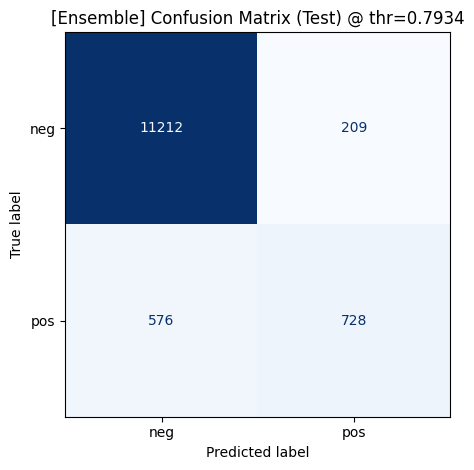

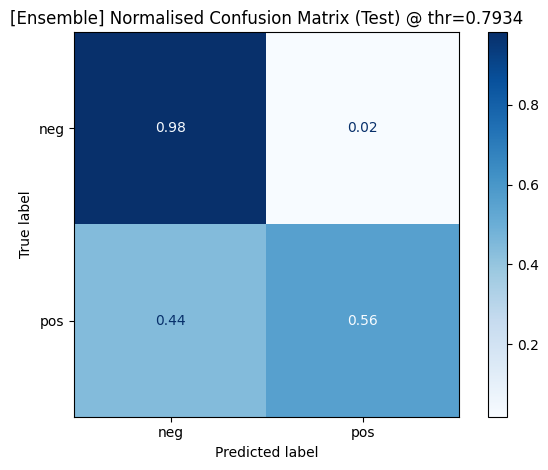

In [25]:
# Raw confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot(values_format="d", cmap="Blues", colorbar=False, ax=ax)
ax.set_title(f"[Ensemble] Confusion Matrix (Test) @ thr={thr_opt_ens:.4f}")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cm_test_ensemble.png"), dpi=160)
plt.show()
plt.close(fig)

# Normalised (row-wise) confusion matrix
cm_norm = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true")
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["neg", "pos"])
disp.plot(values_format=".2f", cmap="Blues", colorbar=True, ax=ax)
ax.set_title(f"[Ensemble] Normalised Confusion Matrix (Test) @ thr={thr_opt_ens:.4f}")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "cm_test_ensemble_normalised.png"), dpi=160)
plt.show()
plt.close(fig)

## Text report

In [10]:
rep = classification_report(
    y_true,
    y_pred,
    digits=4,
    target_names=["neg", "pos"]
)
print(rep)
with open(os.path.join(OUT_DIR, "classification_report_test_ensemble.txt"), "w") as f:
    f.write(f"Threshold used (val max-F1): {thr_opt_ens:.6f}\n\n")
    f.write(rep)

              precision    recall  f1-score   support

         neg     0.9511    0.9817    0.9662     11421
         pos     0.7769    0.5583    0.6497      1304

    accuracy                         0.9383     12725
   macro avg     0.8640    0.7700    0.8079     12725
weighted avg     0.9333    0.9383    0.9337     12725



## PR Curve (Test)

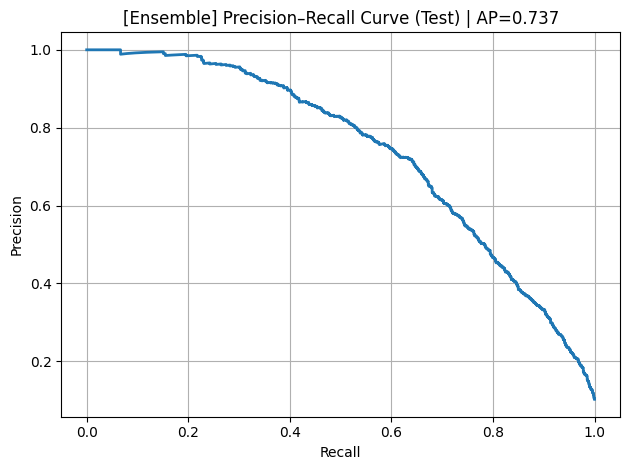

In [26]:
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure()
plt.plot(rec, prec, linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"[Ensemble] Precision–Recall Curve (Test) | AP={average_precision_score(y_true, y_prob):.3f}")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "pr_curve_test_ensemble.png"), dpi=160)
plt.show()

## ROC Curve (Test)

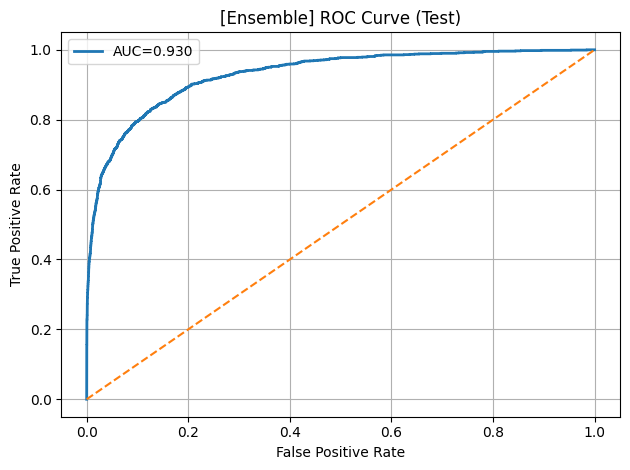

In [27]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, linewidth=2, label=f"AUC={roc_auc_score(y_true, y_prob):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("[Ensemble] ROC Curve (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "roc_curve_test_ensemble.png"), dpi=160)
plt.show()

## Threshold–F1 Curve (Validation)

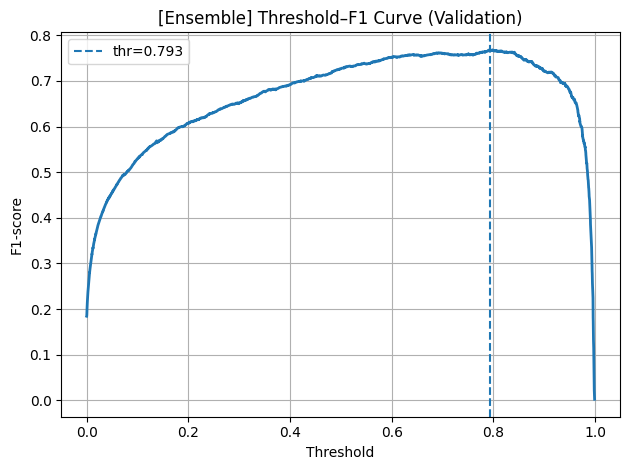

In [28]:
plt.figure()
plt.plot(thr_grid, f1_scores, linewidth=2)
plt.axvline(thr_opt_ens, linestyle="--", label=f"thr={thr_opt_ens:.3f}")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("[Ensemble] Threshold–F1 Curve (Validation)")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig(os.path.join(OUT_DIR, "thr_f1_curve_val_ensemble.png"), dpi=160)
plt.show()

## Score Distribution Plot (Test)

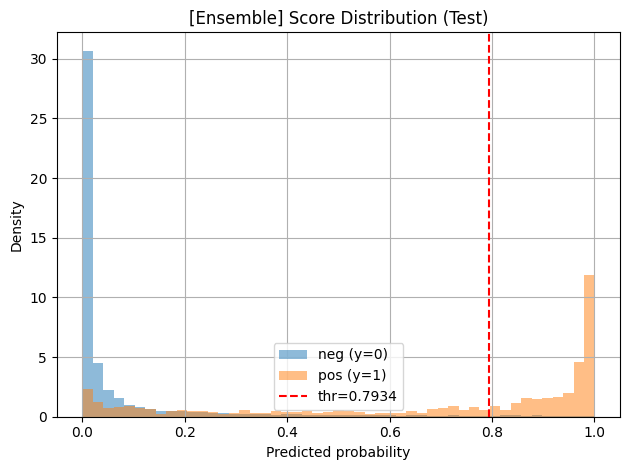

In [29]:
y_test = np.asarray(y_test)
p_test = np.asarray(p_test)

plt.figure()
bins = np.linspace(0, 1, 50)

plt.hist(p_test[y_test == 0], bins=bins, alpha=0.5, label="neg (y=0)", density=True)
plt.hist(p_test[y_test == 1], bins=bins, alpha=0.5, label="pos (y=1)", density=True)

plt.axvline(thr_opt_ens, color='red', linestyle="--", label=f"thr={thr_opt_ens:.4f}")
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("[Ensemble] Score Distribution (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "score_distribution_test_ensemble.png"), dpi=160)
plt.show()

## Calibration Curve (Test)

Brier score (Test): 0.057230


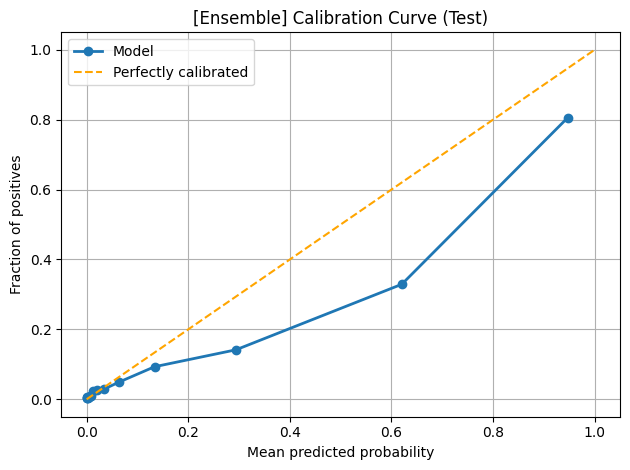

In [30]:
brier = brier_score_loss(y_true, y_prob)
print(f"Brier score (Test): {brier:.6f}")

prob_true, prob_pred = calibration_curve(y_test, p_test, n_bins=15, strategy="quantile")

plt.figure()
plt.plot(prob_pred, prob_true, marker="o", linewidth=2, label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", label="Perfectly calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("[Ensemble] Calibration Curve (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "calibration_curve_test_ensemble.png"), dpi=160)
plt.show()


## Precision@K / Top-K Analysis (Test)

In [16]:
def precision_recall_at_k(y_true, y_score, k):
    """
    y_true: 1D array of 0/1
    y_score: 1D array of predicted probabilities
    k: int, number of top examples to take
    """
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    k = min(k, len(y_true))
    idx = np.argsort(y_score)[::-1][:k] # top-k scores
    topk_true = y_true[idx]

    precision = topk_true.mean()
    recall = topk_true.sum() / (y_true.sum() + 1e-12)
    return precision, recall, topk_true.sum()


def top_fraction_analysis(y_true, y_score, frac):
    """
    frac: fraction of population to flag (e.g., 0.01 for top 1%)
    """
    n = len(y_true)
    k = max(1, int(frac * n))
    return precision_recall_at_k(y_true, y_score, k)

In [17]:
Ks = [100, 500, 1000]
print("Precision@K / Recall@K on Test (Ensemble):")
for K in Ks:
    prec_k, rec_k, tp_k = precision_recall_at_k(y_test, p_test, K)
    print(f"K = {K:5d} | TP in top-K = {tp_k:4d} | Precision@K = {prec_k:.4f} | Recall@K = {rec_k:.4f}")

fractions = [0.001, 0.005, 0.01]
n_test = len(y_test)
print("\nTop-fraction Analysis on Test (Ensemble):")
for frac in fractions:
    prec_f, rec_f, tp_f = top_fraction_analysis(y_test, p_test, frac)
    k = max(1, int(frac * n_test))
    print(f"Top {frac*100:4.1f}% (K={k}) | TP = {tp_f:4d} | Precision = {prec_f:.4f} | Recall = {rec_f:.4f}")

Precision@K / Recall@K on Test (Ensemble):
K =   100 | TP in top-K =   99 | Precision@K = 0.9900 | Recall@K = 0.0759
K =   500 | TP in top-K =  460 | Precision@K = 0.9200 | Recall@K = 0.3528
K =  1000 | TP in top-K =  758 | Precision@K = 0.7580 | Recall@K = 0.5813

Top-fraction Analysis on Test (Ensemble):
Top  0.1% (K=12) | TP =   12 | Precision = 1.0000 | Recall = 0.0092
Top  0.5% (K=63) | TP =   63 | Precision = 1.0000 | Recall = 0.0483
Top  1.0% (K=127) | TP =  126 | Precision = 0.9921 | Recall = 0.0966


## KS Statistic + KS Plot

[Ensemble] KS statistic: 0.7034 at score 0.1974


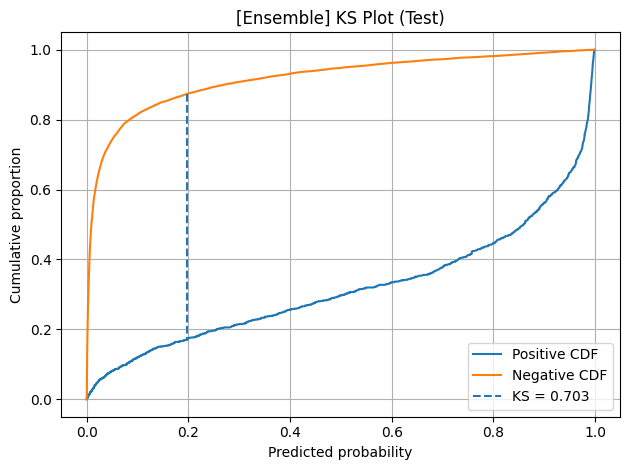

In [32]:
y_t = np.asarray(y_test).astype(int)
p_t = np.asarray(p_test, dtype=float)

# Sort by score ascending (for CDFs)
idx = np.argsort(p_t)
p_sorted = p_t[idx]
y_sorted = y_t[idx]

total_pos = y_sorted.sum()
total_neg = (1 - y_sorted).sum()

# Cumulative distribution for positives and negatives
cum_pos = np.cumsum(y_sorted) / (total_pos + 1e-12)
cum_neg = np.cumsum(1 - y_sorted) / (total_neg + 1e-12)

# KS statistic
ks_values = np.abs(cum_pos - cum_neg)
ks_stat = ks_values.max()
ks_idx = ks_values.argmax()
ks_score = p_sorted[ks_idx]

print(f"[Ensemble] KS statistic: {ks_stat:.4f} at score {ks_score:.4f}")

# Plot two CDFs and mark KS
plt.figure()
plt.plot(p_sorted, cum_pos, label="Positive CDF")
plt.plot(p_sorted, cum_neg, label="Negative CDF")
plt.vlines(p_sorted[ks_idx], cum_neg[ks_idx], cum_pos[ks_idx],
           linestyles="--", label=f"KS = {ks_stat:.3f}")
plt.xlabel("Predicted probability")
plt.ylabel("Cumulative proportion")
plt.title("[Ensemble] KS Plot (Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "ks_plot_test_ensemble.png"), dpi=160)
plt.show()

# SHAP

In [19]:
import shap

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Global SHAP shape: (2000, 768)


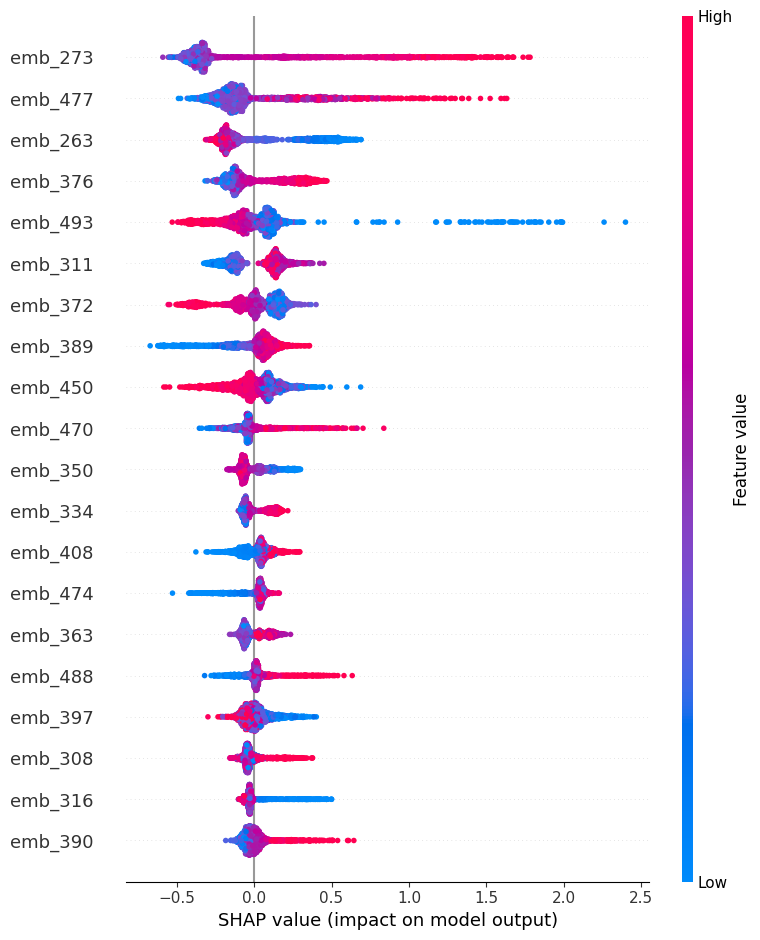

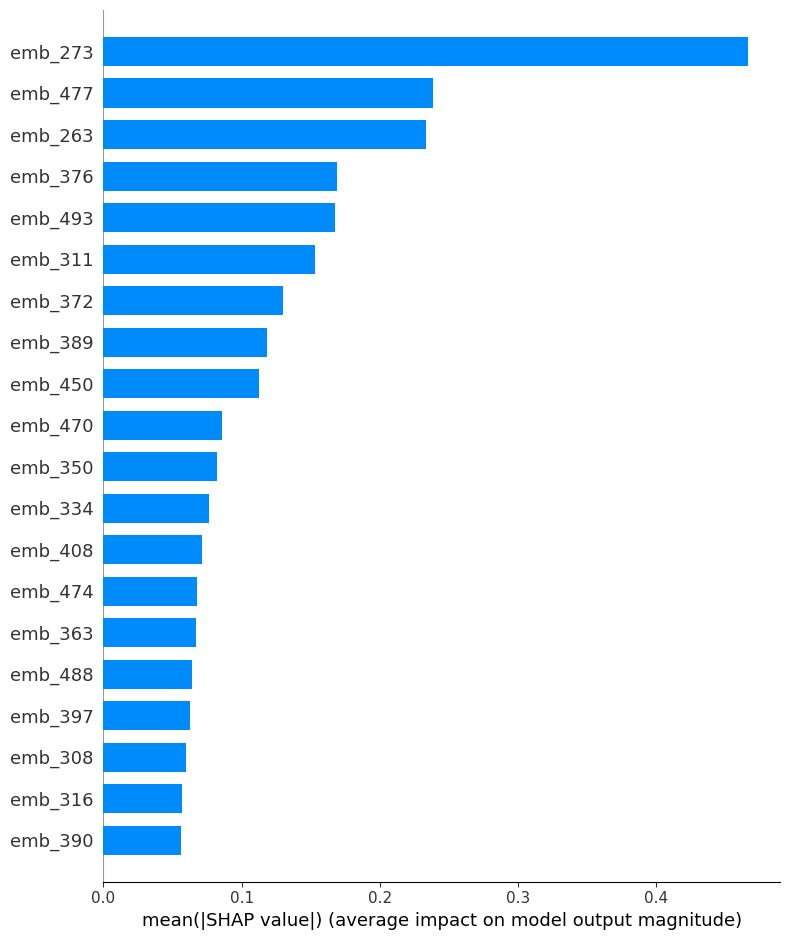

In [20]:
# Build explainer
explainer = shap.TreeExplainer(gbm)

# Background sample for global explanation
X_train_np = np.asarray(X_train, dtype=float)
n_bg = min(2000, X_train_np.shape[0])
rng = np.random.default_rng(42)
idx_bg = rng.choice(X_train_np.shape[0], size=n_bg, replace=False)
X_bg = X_train_np[idx_bg]

# SHAP values
shap_bg = explainer.shap_values(X_bg) # (n_bg, d)
shap_bg = np.asarray(shap_bg, dtype=float)

print("Global SHAP shape:", shap_bg.shape)

# Feature names for embeddings
num_features = X_bg.shape[1]
feature_names = [f"emb_{i}" for i in range(num_features)]

# Global summary (beeswarm)
shap.summary_plot(
    shap_bg,
    X_bg,
    feature_names=feature_names,
    show=True
)

# Global importance bar plot
shap.summary_plot(
    shap_bg,
    X_bg,
    feature_names=feature_names,
    plot_type="bar",
    show=True
)

Example index: 774
Predicted fraud prob: 0.9945357099926448
shap_ex shape: (768,)
base_value: -3.6629406387893737


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


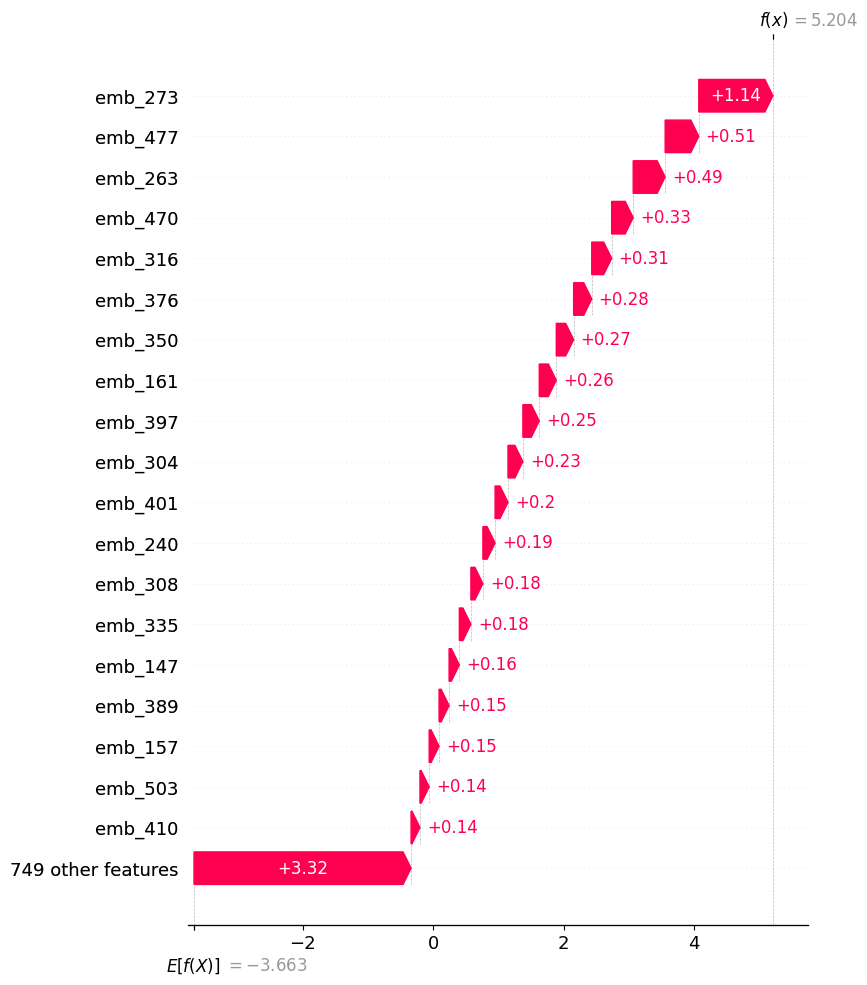

In [21]:
X_test_np = np.asarray(X_test, dtype=float)
y_test_np = np.asarray(y_test, dtype=int)

pos_idx = np.where(y_test_np == 1)[0]
example_idx = int(pos_idx[93]) # chosen example
x_example = X_test_np[example_idx:example_idx+1]

print("Example index:", example_idx)
print("Predicted fraud prob:", float(gbm.predict(x_example)[0]))

# SHAP values for chosen example
sv_ex = explainer.shap_values(x_example)  # (1, d)
sv_ex = np.asarray(sv_ex, dtype=float)
shap_ex = sv_ex[0]  # (d,)

# Expected value
ev = explainer.expected_value
base_value = float(ev[0]) if isinstance(ev, (list, np.ndarray)) else float(ev)

print("shap_ex shape:", shap_ex.shape)
print("base_value:", base_value)

# Waterfall plot (top 20 embedding dimensions)
shap.plots._waterfall.waterfall_legacy(
    base_value,
    shap_ex,
    feature_names=feature_names,
    max_display=20
)